In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
sns.set()

## Disaster Tweets Dataset on Kaggle

This is my first 'real' foray into NLP. And I think given our very simple approach, the result is top-notch.

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
df.shape

(7613, 5)

In [5]:
df['target'].value_counts()/df.shape[0]
#slightly  imbalanced dataset

0    0.57034
1    0.42966
Name: target, dtype: float64

## Text Cleanup

In [6]:
def cleanup(df):
    df.drop(['id','keyword','location'],axis=1,inplace=True) #these are unnecessary
    
    #text cleanup using regex
    df['text'] = df['text'].apply(lambda x: x.lower()) #lower case
    df['text'] = df['text'].apply(lambda x: re.sub('@[\w]+','',x)) #removing twitter handles
    df['text'] = df['text'].apply(lambda x: re.sub('@\s+[\w]+','',x)) #removing twitter handles
    df['text'] = df['text'].apply(lambda x: re.sub('#[\w]+','',x)) #removing hashtags
    df['text'] = df['text'].apply(lambda x: re.sub('#\s+[\w]+','',x)) #removing hashtags
    df['text'] = df['text'].apply(lambda x: re.sub('http\S+','',x)) #removing websites
    df['text'] = df['text'].apply(lambda x: re.sub('www\S+','',x)) #removing websites
    df['text'] = df['text'].apply(lambda x: re.sub('[^\w\s]','',x)) #removes all punctuations, AND emojis
    df['text'] = df['text'].apply(lambda x: re.sub('\w*\d\w*','',x)) #removes all words with digits
    
    df['text'] = df['text'].str.split() #tokenizing
    
    #removing stopwords
    sp = spacy.load('en_core_web_sm')
    stopwords = sp.Defaults.stop_words
    
    df['text'] = df['text'].apply(lambda x: [word for word in x 
                                             if word not in stopwords])
    
    #lemmatizing the words
    wnl = nltk.stem.WordNetLemmatizer()
    df['text'] = df['text'].apply(lambda x: [wnl.lemmatize(word) for word in x])
    
    #removing all words which are single letters. Noticed some words like these after cleanup
    char_list = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
                 'n','o','p','q','r','s','t','u','v','w','x','y','z'] 
    df['text'] = df['text'].apply(lambda x: [word for word in x if word not in char_list])
    
    return df

df = cleanup(df)

#dropping the instances where the cleanup text was basically an empty list
idx = df.loc[df['text'].apply(len) == 0].index
df.drop(idx,axis=0,inplace=True)

In [7]:
df

,text,target
0,"[deed, reason, allah, forgive]",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[resident, asked, shelter, place, notified, of...",1
3,"[people, receive, evacuation, order, california]",1
4,"[got, sent, photo, ruby, smoke, pours, school]",1
...,...,...
7608,"[giant, crane, holding, bridge, collapse, near...",1
7609,"[control, wild, fire, california, northern, st...",1
7610,"[volcano, hawaii]",1
7611,"[police, investigating, ebike, collided, car, ...",1


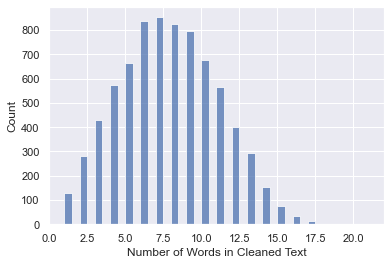

In [8]:
sns.histplot(df['text'].apply(len))
plt.xlabel('Number of Words in Cleaned Text')
plt.show()

## Making Corpus and Vectorizing
Once the corpus has been made, we will vectorize our cleanup dataset as one-hot vectors. 
To account for unknown words in our test dataset, we will make the corpus with 90% of our dataset. Any unknown words, ie, words not in the corpus, will be tokenized as '\[UNK\]'. \[UNK\] token is also added in the corpus.

In [9]:
def make_corpus(df):
    corpus = []
    for i in df['text']:
        [corpus.append(word) for word in i if word not in corpus]
    corpus.append('[UNK]')
    return corpus

corpus = make_corpus(df.sample(frac=0.90,random_state=2,replace=False))  
N = len(corpus)

#Taking care of unknown words. Not too happy with this function because of the for-loops
def unknown_tokens(df):
    for i in df.index:
        for word in df['text'].loc[i]:
            if word not in corpus:
                 df['text'].loc[i][df['text'].loc[i].index(word)] = '[UNK]'  
    return df

df = unknown_tokens(df)

In [10]:
df

,text,target
0,"[deed, reason, allah, forgive]",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[resident, asked, shelter, place, notified, of...",1
3,"[people, receive, evacuation, order, california]",1
4,"[got, sent, photo, ruby, smoke, pours, school]",1
...,...,...
7608,"[giant, crane, holding, bridge, collapse, near...",1
7609,"[control, wild, fire, california, northern, st...",1
7610,"[volcano, hawaii]",1
7611,"[police, investigating, ebike, collided, car, ...",1


In [11]:
#Vectorizing
def make_one_hot(item):
    idx = [corpus.index(i) for i in item]
    v = np.zeros(N)
    v[idx] = 1
    return v
df['vectors'] = df['text'].apply(make_one_hot)
df_vec = pd.DataFrame(df['vectors'].to_list(),columns=[str(i) for i in range(N)])

In [12]:
df_vec

,0,1,2,3,4,5,6,7,8,9,...,11437,11438,11439,11440,11441,11442,11443,11444,11445,11446
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fitting to a Neural Network model

We will use early stopping regularization

In [13]:
#preparing training and test sets
from sklearn.model_selection import train_test_split

trainX, X_test, trainY, y_test = train_test_split(df_vec,df['target'],test_size=0.2,random_state=2)
X_train, X_valid, y_train, y_valid = train_test_split(trainX,trainY,test_size=0.2,random_state=2)

y_train.value_counts()/y_train.shape[0],y_valid.value_counts()/y_valid.shape[0],y_test.value_counts()/y_test.shape[0]

(0    0.574892
 1    0.425108
 Name: target, dtype: float64,
 0    0.593262
 1    0.406738
 Name: target, dtype: float64,
 0    0.538462
 1    0.461538
 Name: target, dtype: float64)

In [14]:
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

In [15]:
def to_tensor(X,y):
    Xt = torch.from_numpy(X).to(torch.float)
    yt = torch.from_numpy(y).reshape(-1,1).to(torch.float)
    return Xt, yt

Xt_train, yt_train = to_tensor(X_train.to_numpy(), y_train.to_numpy())
Xt_valid, yt_valid = to_tensor(X_valid.to_numpy(), y_valid.to_numpy())
Xt_test, yt_test = to_tensor(X_test.to_numpy(), y_test.to_numpy())

In [16]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layers = nn.Sequential(nn.Linear(N,int(N/16)), nn.ReLU(),
                                    
                                    nn.Linear(int(N/16),1), nn.Sigmoid())
        
    def forward(self,x):
        return self.layers(x)
    
def train(model, n_epoch, patience, lr, X_train, X_valid, y_train, y_valid):
    
    model.train()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    printstep = int(n_epoch/10)
    
    last_loss = 100.
    trigger = 0
    
    epoch_loss_train = list()
    epoch_loss_valid = list()
    
    for epoch in range(1,n_epoch+1):
        
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss = criterion(y_pred_train,y_train)
        loss.backward()
        optimizer.step()
        
        if(epoch%printstep == 0):
            print("Epoch {}, Loss {}".format(epoch,loss.item()))
        
        #early stopping
        y_pred_valid = model(X_valid)
        loss_valid = criterion(y_pred_valid,y_valid)
        new_loss = loss_valid.item()
        
        epoch_loss_train.append(loss.item())
        epoch_loss_valid.append(new_loss)
        
        if(new_loss > last_loss):
            trigger += 1
            if(trigger > patience):
                print("Early Stopping at Epoch {}".format(epoch))
                break
        else:
            trigger = 0
        last_loss = new_loss
        
    plt.plot(epoch_loss_train)
    plt.plot(epoch_loss_valid)
    plt.legend(['Training Loss','Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    return model

In [17]:
def model_prediction(X):
    y = model(X).detach().numpy()
    y[y>=0.5] = 1
    y[y<0.5] = 0
    return y

def model_scores(X,y):
    y_pred = model_prediction(X)
    print(classification_report(y,y_pred))    

Epoch 4, Loss 0.6477246880531311
Epoch 8, Loss 0.5668122172355652
Epoch 12, Loss 0.4706699550151825
Epoch 16, Loss 0.37679117918014526
Epoch 20, Loss 0.2970464527606964
Epoch 24, Loss 0.23513983190059662
Early Stopping at Epoch 25


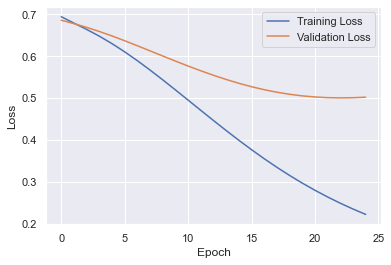

In [18]:
n_epoch = 40
patience = 1
lr = 0.001

model = NN()
model = train(model, n_epoch, patience, lr, Xt_train, Xt_valid, yt_train, yt_valid)

In [19]:
print("Test Set")
model_scores(Xt_test, yt_test)
print("\nTraining Set")
model_scores(Xt_train, yt_train)
print("\nValidation Set")
model_scores(Xt_valid, yt_valid)

Test Set
              precision    recall  f1-score   support

         0.0       0.77      0.85      0.81       819
         1.0       0.80      0.70      0.75       702

    accuracy                           0.78      1521
   macro avg       0.78      0.78      0.78      1521
weighted avg       0.78      0.78      0.78      1521


Training Set
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      2798
         1.0       0.96      0.91      0.94      2069

    accuracy                           0.95      4867
   macro avg       0.95      0.94      0.95      4867
weighted avg       0.95      0.95      0.95      4867


Validation Set
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82       722
         1.0       0.75      0.69      0.72       495

    accuracy                           0.78      1217
   macro avg       0.78      0.77      0.77      1217
weighted avg       0.78      0.78  

### Generating submission for kaggle

In [20]:
test = pd.read_csv('test.csv')
ids = test['id']
test = cleanup(test)
test = unknown_tokens(test)
test['vectors'] = test['text'].apply(make_one_hot)
test_vec = pd.DataFrame(test['vectors'].to_list(),columns=[str(i) for i in range(N)])

test_tensor = torch.from_numpy(test_vec.to_numpy()).to(torch.float)
test_y = model_prediction(test_tensor)

targets = pd.DataFrame(test_y,columns=['target']).astype(int)
submission = pd.concat([ids,targets],axis=1)
submission['target'].value_counts()
submission.to_csv('submission.csv',index=False)

Submission gets a score of 0.78 on kaggle. Not bad considering the very bare-bones approach we used.<br>

#### Dummy Classifier
Lets see the performance of a dummy classifier which gives output based on a 50-50 coin-flip

In [38]:
y_dummy = np.random.choice([0,1],size=y_train.shape[0])
print(classification_report(y_train,y_dummy))

              precision    recall  f1-score   support

           0       0.57      0.48      0.52      2798
           1       0.42      0.50      0.46      2069

    accuracy                           0.49      4867
   macro avg       0.49      0.49      0.49      4867
weighted avg       0.50      0.49      0.49      4867

